### HW_06 Embedding
> **Обучить сиамскую сеть для верификации лиц на датасете LFW**

In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.version.VERSION)

2.3.0-dev20200608


In [2]:
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Загрузка датасета LFW

In [3]:
ds, ds_info = tfds.load('lfw', 
                        split='train', 
                        shuffle_files=True,
                        with_info=True,
                       )

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [5]:
test = ds.take(1)
for example in test:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  label = label.numpy().decode('utf-8')
  print(image.shape, label)

['image', 'label']
(250, 250, 3) John_Abizaid


## Визуализация датасета 

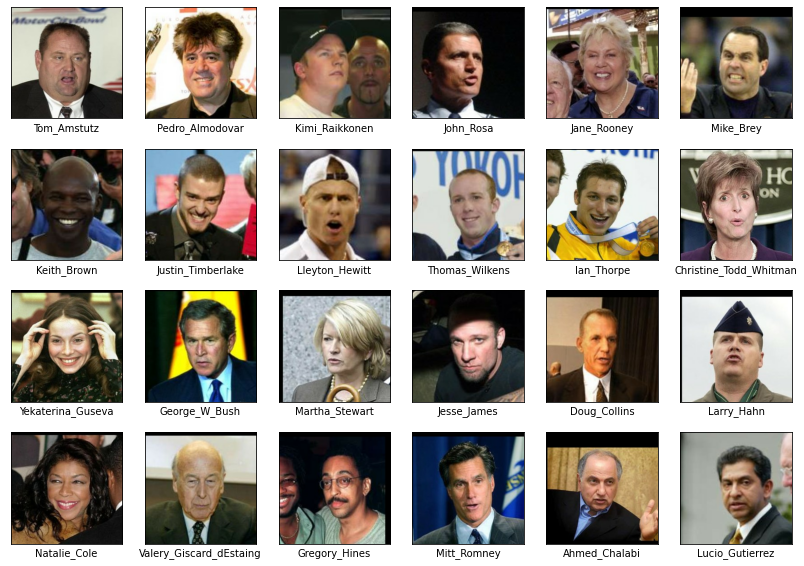

In [6]:
train_ds = ds
fig = plt.figure(figsize=(14, 10))

for j, example in enumerate(train_ds.take(24)):
    image, label = example["image"],  example["label"]
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    label = label.numpy().decode("utf-8")
    ax.set_xlabel(label)
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [7]:
NUM_EPOCHS = 100
BATCH_SIZE = 2
INP_SIZE = 250

In [8]:
def img_prep(img):
    img = tf.cast(img, tf.float32)/255.
    return img

def prepare(img):
    img['image'] = img_prep(img['image'])
    return img

In [9]:
train_ds = ds

train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.shuffle(buffer_size=1000)
# train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
# 
# train_ds = train_ds.window(2, 1).flat_map(lambda x: x)
train_ds = train_ds.batch(BATCH_SIZE)

In [10]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    print(sub)
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows


In [11]:
# train_ds = make_window_dataset(train_ds, window_size=2, shift = 1, stride=1)

## Создание модели CNN

In [12]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [13]:
# Transfer Learning
# base_model = tf.keras.applications.Xception(
#     input_shape=(INP_SIZE, INP_SIZE, 3),
#     include_top=False,
#     weights='imagenet',
# )
# base_model.trainable = True # Fine-tuning весов предобученной модели

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(EMB_SIZE, activation=None),
# ])

## Contrastive Loss

In [14]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    loss = tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)
    if tf.reduce_sum(z)>0:
        print(labels1.numpy(), labels2.numpy())
        print(f'd={d}, z={z}, MAX={tf.maximum(0, MARGIN - d)}, loss={loss}')
    return loss

## Подготовка к обучению

In [15]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [16]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
%%time

for iteration, item in enumerate(train_ds):
    images, labels = item['image'], item['label']
   
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
#         print('[{}] Labels: {}'.format(iteration, labels.numpy()))
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 91.38325500488281
[b'George_W_Bush'] [b'George_W_Bush']
d=[557.8585], z=[1.], MAX=[0.], loss=311206.125
[50] Loss: 0.0
[100] Loss: 0.0
[b'George_W_Bush'] [b'George_W_Bush']
d=[100.538445], z=[1.], MAX=[0.], loss=10107.9794921875
[150] Loss: 0.0
[200] Loss: 0.0
[250] Loss: 0.0
[300] Loss: 0.0
[350] Loss: 0.0
[400] Loss: 0.0
[450] Loss: 0.0
[500] Loss: 0.0
[550] Loss: 0.0
[600] Loss: 0.0
[650] Loss: 0.0
[700] Loss: 0.0
[750] Loss: 0.0
[b'George_W_Bush'] [b'George_W_Bush']
d=[82.787544], z=[1.], MAX=[0.], loss=6853.77783203125
[800] Loss: 0.0
[b'George_W_Bush'] [b'George_W_Bush']
d=[34.820126], z=[1.], MAX=[0.], loss=1212.4410400390625
[850] Loss: 0.0
[b'George_W_Bush'] [b'George_W_Bush']
d=[64.415596], z=[1.], MAX=[0.], loss=4149.369140625
[900] Loss: 0.0
[950] Loss: 0.0
[1000] Loss: 0.0
[1050] Loss: 0.0
[1100] Loss: 0.0
[1150] Loss: 0.0
[1200] Loss: 0.0
[1250] Loss: 0.0
[1300] Loss: 0.0
[1350] Loss: 0.0
[1400] Loss: 0.0
[1450] Loss: 0.0
[1500] Loss: 0.0
[1550] Loss: 0.0
[1600]

In [18]:
tf.get_logger().setLevel(logging.DEBUG)

## Получение эмбеддингов для новых данных

In [19]:
F_NAME='Al_Gore'
def _filter_fn(item):
    label = item['label']
    res = (label == tf.convert_to_tensor(F_NAME))
    return res

f_ds_01 = ds.filter(_filter_fn).shuffle(buffer_size=50).take(2)

In [20]:
# F_NAME='George_W_Bush'
# F_NAME='Yekaterina_Guseva'
F_NAME='Kofi_Annan'

f_ds_02 = ds.filter(_filter_fn).shuffle(buffer_size=50).take(2)

In [21]:
train_ds = f_ds_01.concatenate(f_ds_02).shuffle(buffer_size=10)

In [22]:
embs = []
fig = plt.figure(figsize=(14, 10))

for j, example in enumerate(train_ds):
    image, label = example["image"],  example["label"]
           
    img_t = image[tf.newaxis,:]
    embs.append(model(img_t))
        
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    label = label.numpy().decode("utf-8")
    ax.set_xlabel(label)
    plt.xticks([]), plt.yticks([])
plt.show()

ValueError: Incompatible type conversion requested to type 'uint8' for variable of type 'float32'

<Figure size 1008x720 with 0 Axes>

## Вычисление расстояний между эмбеддингами

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [ ]:
def print_diff(embs):
    for i,a in enumerate(embs):
        for j,b in enumerate(embs):
            print(f'A_{i+1} <--> A_{j+1} = {diff(a,b)}')
        print('='*25)

In [ ]:
print_diff(embs)

## Тестирование на новых данных

In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='constant', anti_aliasing=True)
#     img = (1. - img).astype(np.float32)
#     img = np.mean(img, axis=2)
#     img = np.reshape(img, (250, 250, 1))
    return img

img_a1 = load_and_prepare_image('03_1.jpg')
img_a2 = load_and_prepare_image('01_2.jpg')
img_a3 = load_and_prepare_image('03_3.jpg')
img_a4 = load_and_prepare_image('01_4.jpg')

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_a4)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_a4), axis=0))

In [ ]:
print_diff(new_embs)